In [1]:
# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import data
import numpy as np
import yfinance as yf
from datetime import date, timedelta

In [3]:
symbol = "ROSSELLIND.NS"
start_time = date.today() - timedelta(days=40)
end_time = date.today()

In [4]:
fivemin = yf.download(symbol, interval='5m', start=start_time, end=end_time, index_col=0, parse_dates=True)

[*********************100%***********************]  1 of 1 completed


In [5]:
df = fivemin

In [6]:
# fivemin
df.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-03-16 09:15:00+05:30,156.000000,164.000000,156.000000,163.149994,163.149994,0
2022-03-16 09:20:00+05:30,163.850006,165.000000,162.050003,165.000000,165.000000,24214
2022-03-16 09:25:00+05:30,165.000000,166.600006,164.500000,166.500000,166.500000,32718
2022-03-16 09:30:00+05:30,166.300003,166.850006,163.500000,164.500000,164.500000,16896
2022-03-16 09:35:00+05:30,164.899994,165.850006,164.550003,165.000000,165.000000,16360


In [7]:
df['5ema'] = df['Close'].rolling(5).mean()

In [8]:
df = df.dropna()

In [9]:
# entry candle is the one which is above 5 ema and doesnt touch 5ema line.
df['entry_candle'] = np.nan
df.loc[(df['5ema'] < df['Low']), 'entry_candle'] = 1

/Users/prince/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Users/prince/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [13]:
# now we need to look for a candle which crosses the entry candle low, that will be the buy price.
df['signal'] = np.nan
df['buy_price'] = np.nan
df['sell_price'] = np.nan
entry_candle_index = -1
in_trade = False
length_of_signal_candle = -1
buy_price = -1
for idx in df.index:
    
    if not in_trade:
    # if we have found the entry candle and we arent in a trade
        if entry_candle_index != -1:
            if df['Low'][idx] < df['Low'][entry_candle_index]:
                df['signal'][idx] = 1
                length_of_signal_candle = df['High'][idx] - df['Low'][idx]
                buy_price = df['Low'][entry_candle_index]
                df['buy_price'][idx] = df['Low'][entry_candle_index]
                in_trade = True

        # find the entry candle, given we are not in any trade.
        if df['entry_candle'][idx] == 1:
            entry_candle_index = idx
        
    else:
        # if we are in a trade
        # either we hit SL
        if df['High'][idx] >= buy_price + length_of_signal_candle:
            df['sell_price'][idx] = buy_price + length_of_signal_candle
            df['signal'][idx] = -1
            length_of_signal_candle = -1
            buy_price = -1
            in_trade = False
        # or we hit the target.
        elif df['Low'][idx] >= buy_price - 2 * length_of_signal_candle:
            df['sell_price'][idx] = buy_price - 2 * length_of_signal_candle
            df['signal'][idx] = -1
            length_of_signal_candle = -1
            buy_price = -1
            in_trade = False
            
        

/Users/prince/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/var/folders/1r/4l552nf17t77rvcg5njtz4540000gn/T/ipykernel_62307/1993942451.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][idx] = 1
/var/folders/1r/4l552nf17t77rvcg5njtz4540000gn/T/ipykernel_62307/1993942451.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [14]:
df[(df.signal == 1) | (df.signal == -1)]

,Open,High,Low,Close,Adj Close,Volume,5ema,entry_candle,signal,buy_price,sell_price
Datetime,,,,,,,,,,,
2022-03-16 09:55:00+05:30,164.649994,167.000000,164.500000,166.850006,166.850006,11762,165.070001,NaN,1.0,164.600006,NaN
2022-03-16 10:00:00+05:30,166.399994,166.449997,165.350006,166.000000,166.000000,4666,165.270001,1.0,-1.0,NaN,159.600006
2022-03-16 10:10:00+05:30,165.050003,165.300003,164.250000,164.750000,164.750000,3185,165.530002,NaN,1.0,164.600006,NaN
2022-03-16 10:15:00+05:30,164.600006,164.800003,164.500000,164.500000,164.500000,1823,165.440002,NaN,-1.0,NaN,162.500000
2022-03-16 10:20:00+05:30,164.500000,164.500000,164.050003,164.199997,164.199997,1801,164.910001,NaN,1.0,164.600006,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-22 09:55:00+05:30,219.300003,219.800003,217.500000,219.800003,219.800003,6295,217.710004,NaN,1.0,221.100006,NaN
2022-04-22 10:00:00+05:30,219.550003,220.000000,217.000000,217.050003,217.050003,7280,217.860004,NaN,-1.0,NaN,216.500000
2022-04-22 10:05:00+05:30,217.399994,217.800003,216.000000,217.300003,217.300003,6921,218.050003,NaN,1.0,221.100006,NaN


In [17]:
tradesdf = df[(df.signal == 1) | (df.signal == -1)]
tradesdf.head()

,Open,High,Low,Close,Adj Close,Volume,5ema,entry_candle,signal,buy_price,sell_price
Datetime,,,,,,,,,,,
2022-03-16 09:55:00+05:30,164.649994,167.000000,164.500000,166.850006,166.850006,11762,165.070001,NaN,1.0,164.600006,NaN
2022-03-16 10:00:00+05:30,166.399994,166.449997,165.350006,166.000000,166.000000,4666,165.270001,1.0,-1.0,NaN,159.600006
2022-03-16 10:10:00+05:30,165.050003,165.300003,164.250000,164.750000,164.750000,3185,165.530002,NaN,1.0,164.600006,NaN
2022-03-16 10:15:00+05:30,164.600006,164.800003,164.500000,164.500000,164.500000,1823,165.440002,NaN,-1.0,NaN,162.500000
2022-03-16 10:20:00+05:30,164.500000,164.500000,164.050003,164.199997,164.199997,1801,164.910001,NaN,1.0,164.600006,NaN


In [25]:
# because this is a shorting trade.
tradesdf['pnl'] = tradesdf.buy_price.shift(1) - tradesdf.sell_price

/Users/prince/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


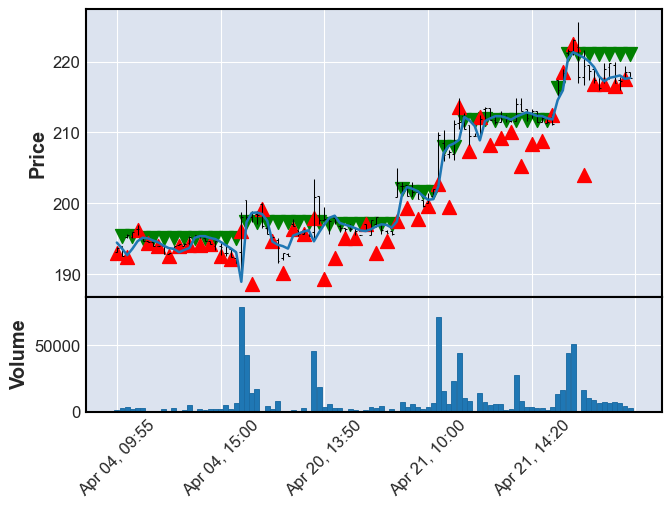

In [30]:
import mplfinance as mpf

def plot(df):
    apds = [
        mpf.make_addplot(df['5ema']),
#         mpf.make_addplot(df['signal'] ,type='scatter', markersize=100, marker='v'),
        mpf.make_addplot(df['buy_price'] ,type='scatter', markersize=100, marker='v', color='g'),
        mpf.make_addplot(df['sell_price'] ,type='scatter', markersize=100, marker='^', color='r')
    ]
    
    mpf.plot(df, volume=True, addplot=apds)
    
    
plot(tradesdf.tail(100))